In [1]:
import torch
import fastai
torch.cuda.is_available()

True

In [2]:
import torch.nn as nn
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
from math import prod,sqrt
from pathlib import Path

In [3]:
!ls 

Modelos manuales.ipynb	birds	birds2.zip  flowers
archive			birds2	data	    models


In [4]:
!ls birds/images

train  valid


In [3]:
birds = Path("birds/")
files = fv.get_image_files("birds/images/"); files

(#11788) [Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0019_22806.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0026_796963.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0002_796959.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0023_796979.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0004_796957.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0055_796973.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0030_796994.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0051_796991.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0028_796988.jpg'),Path('birds/images/valid/Chuck_Will_Widow/Chuck_Will_Widow_0021_796952.jpg')...]

In [10]:
def load_data(folder, img_size, batch_size):  
    tfms = fv.aug_transforms(flip_vert=True, max_rotate=360, max_lighting=0.45,max_zoom=1.2,max_warp=0.42)
    
    data = fv.DataBlock(
                        blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(folder,bs=batch_size)

In [13]:
data1 = load_data(birds, img_size=224, batch_size=64)

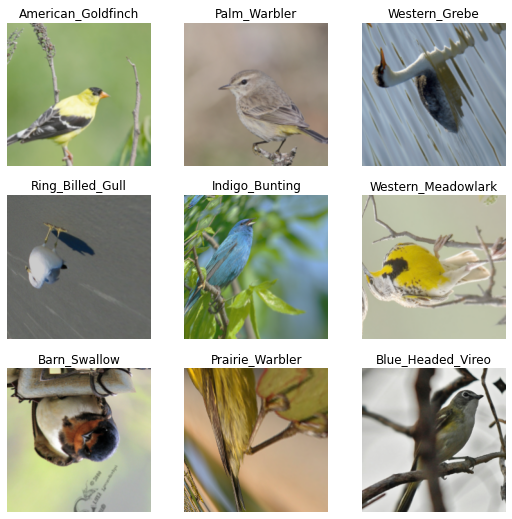

In [8]:
data1.show_batch()

In [14]:
class Flatten(nn.Module):
    def __init__(self):#init es cuando creas un objeto siempre
        super().__init__() #esto tambien es de cajon en todos los modulos de python
    
    def forward(self,x): #esta funcion lo unico que hace es pasar de convolucional a la parte lineal o densa
        #return x.squeeze() #esto tiene un pequeño error cuando la Batch Size sea de 1: la va a quitar
        return x.view(x.shape[0],-1) #o x.reshape

def num_params(model):
    total = 0
    for p in model.parameters():
        num = 1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [15]:
model_bn = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3,32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128,256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256,512, kernel_size=3, stride=2, padding=1),
    nn.Sigmoid(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.BatchNorm1d(512),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data1.c))

In [11]:
num_params(model_bn)

1753742

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=1.9054607491852948e-06)

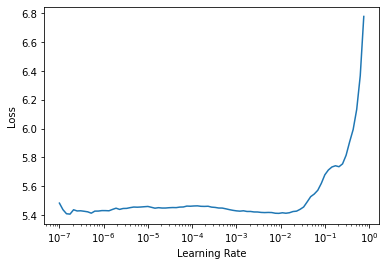

In [12]:
learner1 = fv.Learner(data1,model_bn,metrics=fv.accuracy)
learner1.lr_find()

In [13]:
learner1.fit_one_cycle(14,lr_max=0.00109) 

In [14]:
learner1.save("inicial")

Path('models/inicial.pth')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.981071586167673e-06)

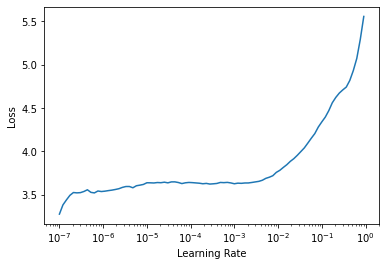

In [15]:
learner1.lr_find()

In [16]:
learner1.fit_one_cycle(12, lr_max=slice(6.31e-8,3.8e-6)) #ja... no entiendo cómo lo hace si no partí el modelo 

In [16]:
def my_own_splitter(m):
    return [list(group.parameters()) for group in [m[0:4], m[4:12], m[12:19], m[19:]]]

In [18]:
learner1 = fv.Learner(data1,model_bn,
                   opt_func=fv.ranger,metrics=fv.accuracy,
                   splitter=my_own_splitter
                  )

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

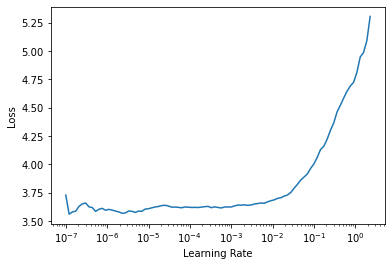

In [19]:
learner1.lr_find()

In [20]:
learner1.fit_one_cycle(15, lr_max=slice(7.6e-7,2.2e-7)) #esto está espantoso, muy oscilante.

De esto anterior: No hay mayores cambios.

In [17]:
model_bn = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3,32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128,256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256,512, kernel_size=3, stride=2, padding=1),
    nn.Sigmoid(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.BatchNorm1d(512),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data1.c))

In [5]:
flowers = Path("flowers/")
files = fv.get_image_files("flowers/"); files

(#8189) [Path('flowers/valid/morning-glory/image_02471.jpg'),Path('flowers/valid/morning-glory/image_02512.jpg'),Path('flowers/valid/morning-glory/image_02516.jpg'),Path('flowers/valid/morning-glory/image_02496.jpg'),Path('flowers/valid/morning-glory/image_02491.jpg'),Path('flowers/valid/morning-glory/image_02475.jpg'),Path('flowers/valid/morning-glory/image_02502.jpg'),Path('flowers/valid/hippeastrum/image_04865.jpg'),Path('flowers/valid/hippeastrum/image_04846.jpg'),Path('flowers/valid/hippeastrum/image_04833.jpg')...]

In [4]:
def load_data(folder, img_size, batch_size):  
    tfms = fv.aug_transforms(flip_vert=True, max_rotate=360, max_lighting=0.45,max_zoom=1.2,max_warp=0.42)
    
    data = fv.DataBlock(
                        blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(folder,bs=batch_size)

In [24]:
data = load_data(flowers, img_size=224, batch_size=64)

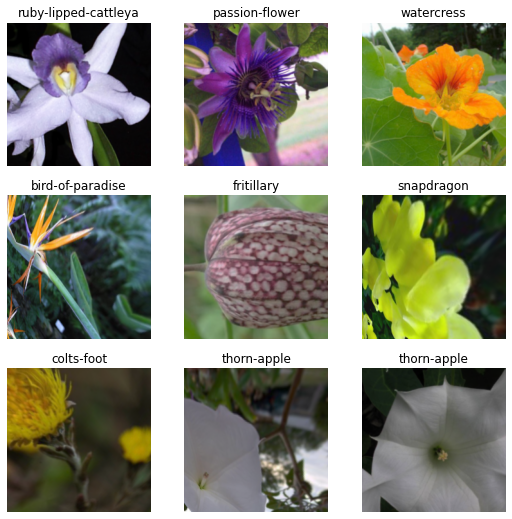

In [25]:
data.show_batch()

In [33]:
learner2 = fv.Learner(data,model_bn,opt_func=fv.ranger,metrics=fv.accuracy,splitter=my_own_splitter)
learner2.load("Pre-Tra")

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.02290867641568184)

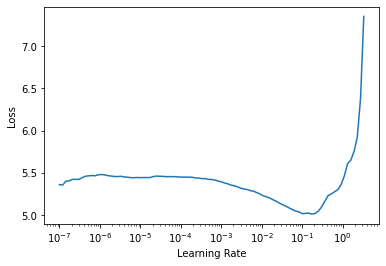

In [34]:
learner2.lr_find()

In [28]:
learner2.save("Pre-Tra")

Path('models/Pre-Tra.pth')

¡Esto se ve más prometedor!

In [35]:
learner2.fit_one_cycle(14,5e-3)

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=1.5848931980144698e-06)

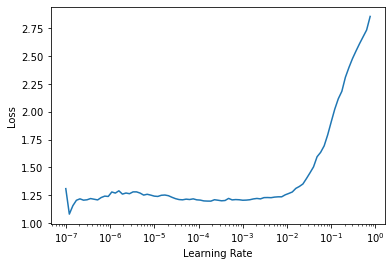

In [36]:
learner2.lr_find()

In [37]:
learner2.save("Tra1")

Path('models/Tra1.pth')

In [38]:
learner2.fit_one_cycle(30, lr_max=slice(1.6e-6,1.8e-5))

In [39]:
learner2.save("Tra2")

Path('models/Tra2.pth')

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=6.309573450380412e-07)

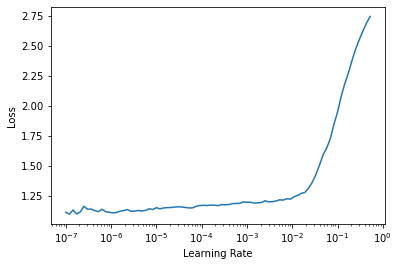

In [40]:
learner2.lr_find()

In [41]:
learner2.fit_one_cycle(15, lr_max=slice(6.3e-7,1e-7))

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=9.12010818865383e-07)

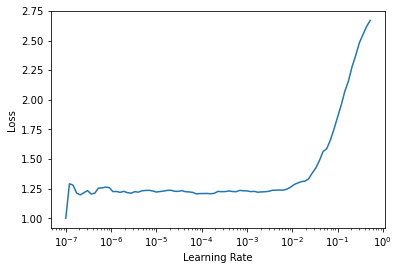

In [42]:
learner2.lr_find()

Parece ser que esto ya no va a mejorar mucho entonces pasemos con congelar una parte.

In [43]:
learner2.load("Tra2")

In [44]:
learner2.freeze_to(-1)

In [45]:
learner2.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm2d          64 x 3 x 224 x 224   6          True      
________________________________________________________________
Conv2d               64 x 32 x 112 x 112  896        False     
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 32 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 28 x 28    18,496     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 28 x 28    128        True      
________________________________________________________________
ReLU                 64 x 64 x 28 x 28    0          False     
_________________________________________________

Y la verdad no me encanta que mi training set quedó terrible entonces voy a hacer una pausa para arreglarlo con .stem o algo así. Eliminaré mi training set y haré esto... tal vez hasta me anime a hacer el inciso anterior pero ya con training sets más chidos.

In [46]:
import pandas as pd
import random

De lo siguiente podía servirme mucho, pero luego me fui a comer y tuve una epifanía muy tonta donde me di cuenta que perdí mi tiempo... entonces lo siguiente: no poner atención

In [49]:
labels_ = pd.read_csv('birds2/Birds/image_class_labels.txt', sep=" ", header=None)
labels_.columns = ["Image","type"]
labels_.set_index("Image",inplace=True)

classes = pd.read_csv('birds2/Birds/classes.txt',sep=" ", header=None)
classes.columns=["Class","Name"]
classes.set_index("Class",inplace=True) 

In [50]:
a_dictionary = {}
a_file = open("birds2/Birds/classes.txt")
for line in a_file:
    key, value = line.split()
    a_dictionary[key] = value

In [51]:
for i in range(len(a_dictionary)):
    llave= str(i+1)
    valor = a_dictionary[llave]
    valor = valor[4:]
    a_dictionary[llave] = valor


In [52]:
y = []
for i in range(len(labels_['type'])):
    buscar = str(labels_.iloc[i][0])
    y.append(a_dictionary[buscar])

labels_["Y"] = y
labels_

type                       Y
Image                              
1         1  Black_footed_Albatross
2         1  Black_footed_Albatross
3         1  Black_footed_Albatross
4         1  Black_footed_Albatross
5         1  Black_footed_Albatross
...     ...                     ...
11784   200     Common_Yellowthroat
11785   200     Common_Yellowthroat
11786   200     Common_Yellowthroat
11787   200     Common_Yellowthroat
11788   200     Common_Yellowthroat

[11788 rows x 2 columns]

## PONER ATENCIÓN AQUÍ

In [4]:
birds2 = Path("birds2/Birds/images")
files = fv.get_image_files("birds2/Birds/images/"); files

(#11788) [Path('birds2/Birds/images/Worm_Eating_Warbler_0063_795553.jpg'),Path('birds2/Birds/images/Kentucky_Warbler_0047_165298.jpg'),Path('birds2/Birds/images/Tree_Sparrow_0043_124034.jpg'),Path('birds2/Birds/images/Chipping_Sparrow_0005_108931.jpg'),Path('birds2/Birds/images/Cliff_Swallow_0041_134111.jpg'),Path('birds2/Birds/images/Wilson_Warbler_0133_175626.jpg'),Path('birds2/Birds/images/Mockingbird_0030_79876.jpg'),Path('birds2/Birds/images/Wilson_Warbler_0075_175234.jpg'),Path('birds2/Birds/images/Shiny_Cowbird_0025_24444.jpg'),Path('birds2/Birds/images/White_Pelican_0025_97604.jpg')...]

In [18]:
def obtener_categorias(f):
    lab = ""
    f = f.stem
    num = ["0","1","2","3","4","5","6","7","8","9"]
    for i in f:
        if i not in num and i!="_":
            lab += i
        if i=="_":
            lab += " "
            
    lab = lab[:-2]
    return lab

In [56]:
obtener_categorias(files[20])

'Palm Warbler'

In [19]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(flip_vert=True, 
                             max_rotate=360, 
                             max_lighting=0.3,
                             max_zoom=1.2,
                             max_warp=0.2)
    
    data = fv.DataBlock( blocks = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y = obtener_categorias,
                        splitter = fv.RandomSplitter(1/10), #voy a dejar 10% de validación
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms = tfms)
    return data.dataloaders(folder, bs=batch_size)

In [20]:
data = load_data(birds2, img_size=224, batch_size=128)

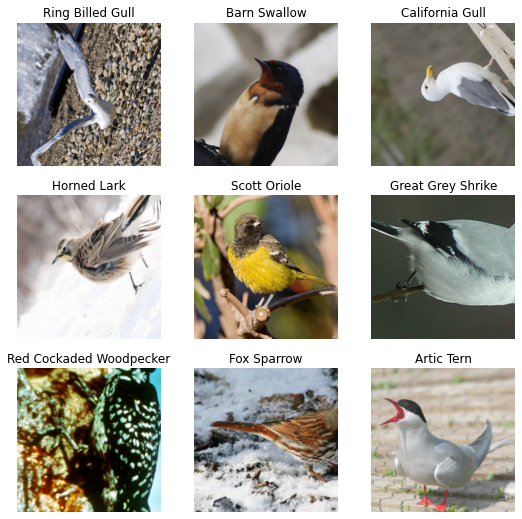

In [59]:
data.show_batch() #¡Erueka!

In [21]:
learner3 = fv.Learner(data,model_bn,opt_func=fv.ranger,metrics=fv.accuracy,splitter=my_own_splitter)

In [61]:
learner3.summary()

Sequential (Input shape: ['128 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm2d          128 x 3 x 336 x 336  6          True      
________________________________________________________________
Conv2d               128 x 32 x 168 x 16  896        False     
________________________________________________________________
ReLU                 128 x 32 x 168 x 16  0          False     
________________________________________________________________
MaxPool2d            128 x 32 x 84 x 84   0          False     
________________________________________________________________
Conv2d               128 x 64 x 42 x 42   18,496     False     
________________________________________________________________
BatchNorm2d          128 x 64 x 42 x 42   128        True      
________________________________________________________________
ReLU                 128 x 64 x 42 x 42   0          False     
________________________________________________

Todo menos la última capa está congelado

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.02754228748381138)

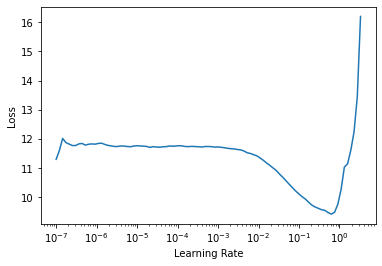

In [62]:
learner3.lr_find()

In [63]:
learner3.fit_one_cycle(20,lr_max=4e-2)

Aún cuando estoy alcanzando menos accuracy que en lo anterior, con 10 epochs y sin hacer slice estoy alcanzando más rápido la accuracy que en el modelo anterior (aunque aún haré experimentos con la nueva forma de pasar los datos).

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=1.0964781722577754e-06)

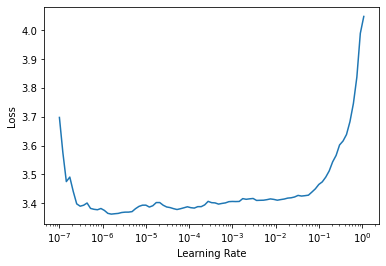

In [64]:
learner3.lr_find()

In [65]:
learner3.save("Tra3")
learner3.fit_one_cycle(30,lr_max=slice(1.5e-7,1.09e-6))

Estoy haciendo 30 epochs para comparar lo que logro con el modelo sin pre-entrenar. Aaaaunque aún falta descongelar y así. La vez anterior: train loss: 3.657191 valid loss: 3.411012 accuracy: 0.165535

Me está costando mucho subir. Si quiero lograr algo decente cuando descongele, tengo que llegar a un 60% al menos ahorita. Voy a intentar ya con div, pct_start y con div_final, además con slice para ver si puedo mejorar estos valores considerablemente. Usaré los valores que me recomienda lr_find().

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=1.3182567499825382e-06)

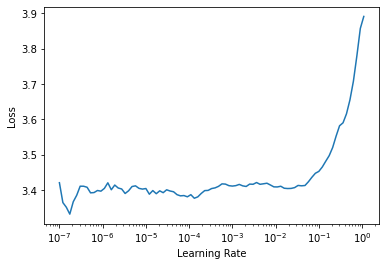

In [67]:
learner3.lr_find()

In [68]:
learner3.fit_one_cycle(5,lr_max=slice(1.31e-6,1.31e-5),div=0.9,div_final=10000,pct_start=0.8)

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=1.2022644114040304e-05)

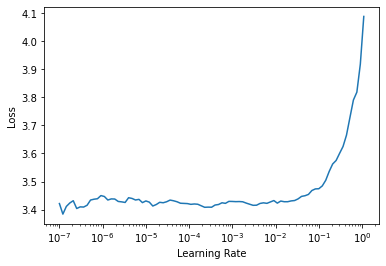

In [69]:
learner3.lr_find()

In [70]:
learner3.fit_one_cycle(40,lr_max=2.3e-5,div=0.9,div_final=10000,pct_start=0.8) #Esto se llama desesperación

In [71]:
learner3.save("Tra4")

Path('models/Tra4.pth')

In [72]:
#Me rendí:
learner3.unfreeze()

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=1.2022644114040304e-05)

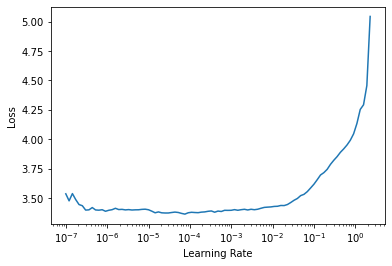

In [73]:
learner3.lr_find()

In [22]:
learner3.load("Tra4")

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=2.2908675418875646e-06)

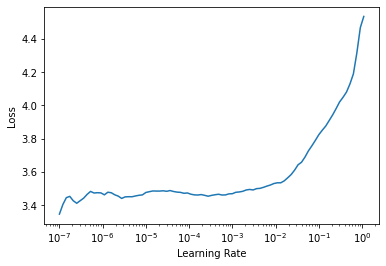

In [23]:
learner3.lr_find()

In [24]:
learner3.fit_one_cycle(5, lr_max=3e-7)

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=7.585775847473997e-07)

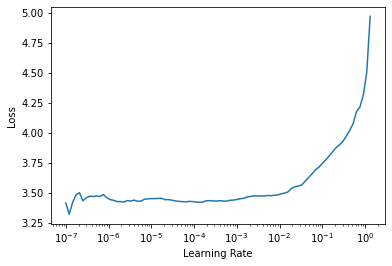

In [25]:
learner3.lr_find()

In [26]:
learner3.fit_one_cycle(20,lr_max=slice(7.6e-7,1.3e-5),div=0.9,div_final=10000,pct_start=0.8)

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

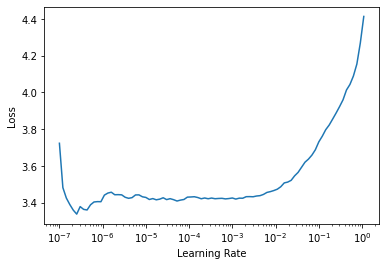

In [27]:
learner3.lr_find()

In [28]:
learner3.fit_one_cycle(15,6.31e-8) #Bueno, no estoy triunfando en la vida

# Plan de acción:
1. Etrenar con el de las flores un nuevo modelo.
2. Congelar y dejar libres las últimas capas.
3. Re-entrenar con el de las aves.

In [41]:
data = load_data(flowers, img_size=224, batch_size=64)

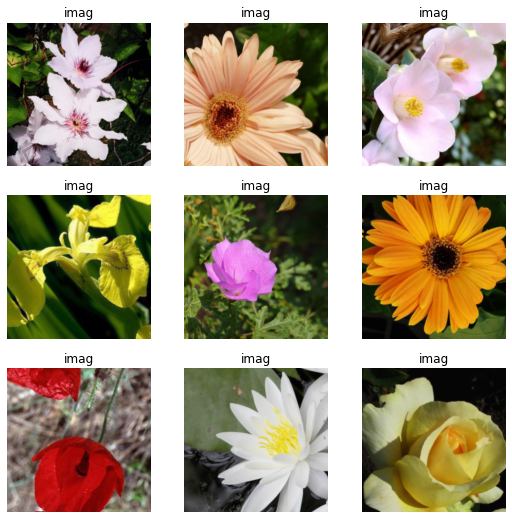

In [49]:
data.show_batch()

In [51]:
model_bn_n = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3,32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128,256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256,512, kernel_size=3, stride=2, padding=1),
    nn.Sigmoid(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.BatchNorm1d(512),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data.c))

In [52]:
model_bn_n

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, strid

In [53]:
def my_own_splitter(m): #solamente para recordarlo
    return [list(group.parameters()) for group in [m[0:4], m[4:12], m[12:19], m[19:]]]

In [54]:
learner_final_1 = fv.Learner(data,model_bn,opt_func=fv.ranger,metrics=fv.accuracy,splitter=my_own_splitter)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.03981071710586548)

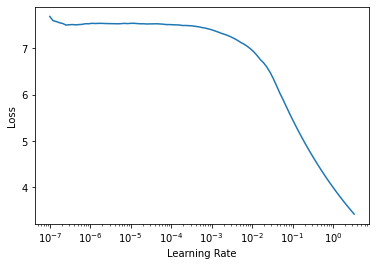

In [55]:
learner_final_1.lr_find() #Jajaja khé? Life can't be that beautiful

In [56]:
learner_final_1.fit_one_cycle(20,lr_max=0.331) #No te creo nada, la verdad...  Me da mucho miedo estar sobre ajustando esto. 

KeyboardInterrupt: 

Antes que nada pase: voy a congelar esto y guardar el learner. 

In [57]:
learner_final_1.save("stage1")

Path('models/stage1.pth')

In [66]:
learner_final_1.freeze_to(-1)

In [71]:
data_birds = load_data(birds2, img_size=224, batch_size=64)

In [74]:
model_bn_n[-1] = nn.Linear(256, data_birds.c)

In [76]:
learner_final_2 = fv.Learner(data_birds,model_bn_n, opt_func=fv.ranger, metrics=fv.accuracy, splitter=my_own_splitter)

In [77]:
learner_final_2.summary()

Sequential (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm2d          64 x 3 x 336 x 336   6          True      
________________________________________________________________
Conv2d               64 x 32 x 168 x 168  896        True      
________________________________________________________________
ReLU                 64 x 32 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 32 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 42 x 42    18,496     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 42 x 42    128        True      
________________________________________________________________
ReLU                 64 x 64 x 42 x 42    0          False     
_________________________________________________

In [ ]:
learner_final_2.lr_find()

In [80]:
learner_final_2.fit_one_cycle(5,lr_max = 0.00275)

Por accidente convertí a markdown una celda de código, pero en esa gráfica no había ninguna curva, así que voy a tratar de que se haga bonito esto con pocas épocas y tratando de elgir un buen learning rate antes de pasar a lo serio serio. Creo que 16 de accuracy para 5 epochs está muuuuy bien. Me preocupaba mucho que se sobre entrenara mi red dado el 1.0 de accuracy en la parte anterior. 

In [81]:
learner_final_2.save("Stage2")

Path('models/Stage2.pth')

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=1.4454397387453355e-05)

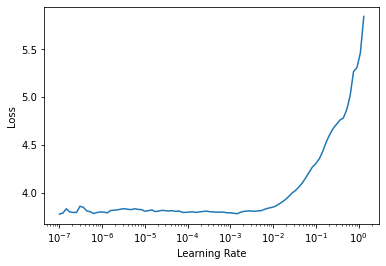

In [82]:
learner_final_2.lr_find()

Bueno, eso se ve un pooooco mejor que hace rato. 

In [83]:
learner_final_2.fit_one_cycle(10,lr_max=1.4e-4)

## Quick recap:

Francamente las gráficas no se ven taaan guapas, pero no voy a negar que está siento muchísimo más sencillo elevar la accuracy con pocas épocas y sin usar muchas cosas. Valid loss va reduciendo poquiiito a poquito, pero se va a lograr. Tengo más fe esta vez. 

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=6.30957365501672e-05)

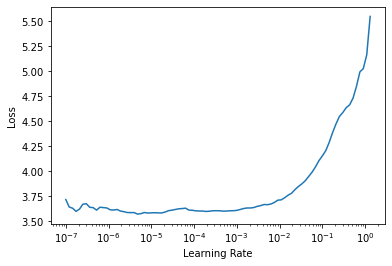

In [85]:
learner_final_2.lr_find()

In [86]:
learner_final_2.save("Stage3")
learner_final_2.fit_one_cycle(20, lr_max=slice(4.8e-7,1e-5))

Okey, esta vez parece que no elegí muy bien mi learning rate. Oh, well... aunque sí veo que está bajando la valid loss, despacito, pero está bajando. 

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=9.12010818865383e-07)

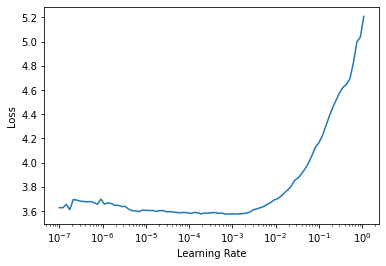

In [87]:
learner_final_2.lr_find()

In [89]:
learner_final_2.fit_one_cycle(7,lr_max=5e-6,div=0.9,div_final=10000,pct_start=0.8)

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=5.248074739938602e-05)

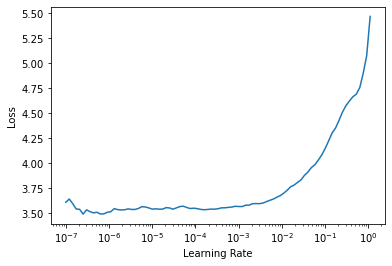

In [90]:
learner_final_2.lr_find()

In [92]:
learner_final_2.fit_one_cycle(15, lr_max=slice(6.31e-8,1e-5),div=0.85,div_final=1000,pct_start=0.8) 
#Aquí estoy experimentando ya con otros div y div_final

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=6.309573450380412e-07)

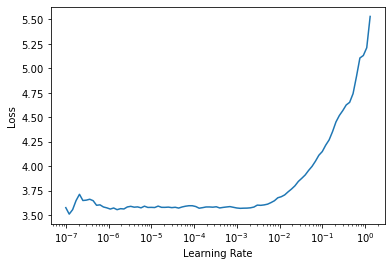

In [93]:
learner_final_2.lr_find()

In [94]:
learner_final_2.fit_one_cycle(30, lr_max=slice(1.58e-7,6.3e-7),div=0.85,div_final=1000,pct_start=0.8) 

### Hasta ahora: 
En las veces pasadas donde quería entrenar sin pre-entrenamiento, llegar a estos números me estaba costando mucho, aun congenlando y demás. Vamos a ver qué tal sale esto ya entrenando toda la red. 

De esto último que vemos arriba: a veces había cosas esperanzadoras como en la época 7 a 8 porque había cambios más grandes, pero luego caíamos como en la época 10 y 11 donde estaba todo como si no lo hubiera entrenado en la vida. Es un poco decepcionante pensar que mi red manual no llega tan rápido a buenas accuracies a como lo hace resnet... but c'mon! Es muy bueno porque solamente estoy pre entrenando con "pocas imágenes". Con mucha paciencia, creo que se podría lograr un muy buen aprendizaje.  

In [95]:
learner_final_2.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=2.2908675418875646e-06)

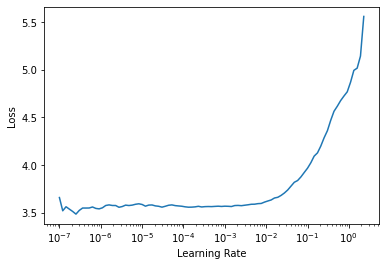

In [96]:
learner_final_2.lr_find()

In [97]:
learner_final_2.fit_one_cycle(7,lr_max=9.1e-8)

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=1.5848931980144698e-06)

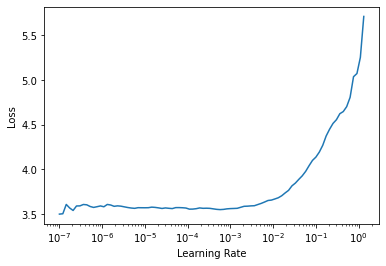

In [98]:
learner_final_2.lr_find()

In [99]:
learner_final_2.fit_one_cycle(20,lr_max=slice(1.6e-6,5.7e-5),div=0.85,div_final=1000,pct_start=0.8) 

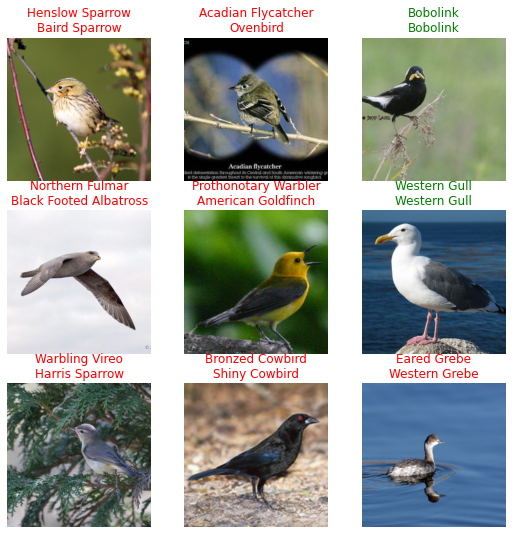

In [100]:
learner_final_2.show_results()

In [103]:
interp=fv.ClassificationInterpretation.from_learner(learner_final_2)

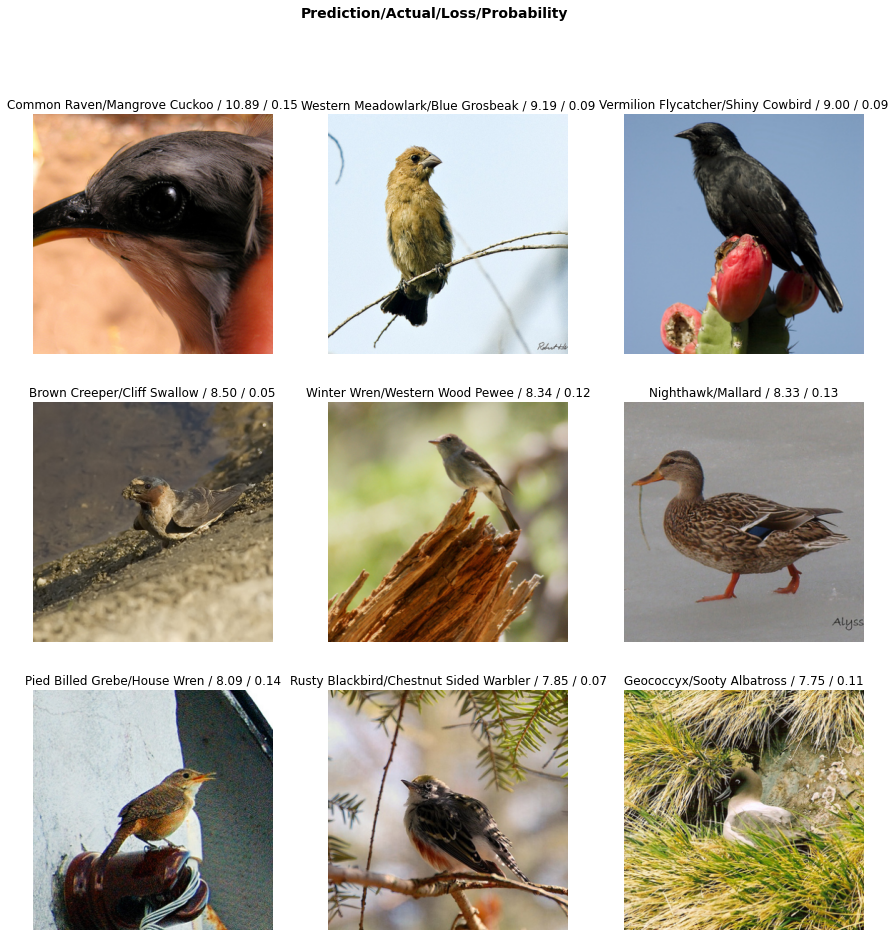

In [108]:
interp.plot_top_losses(9, figsize=(15,15))

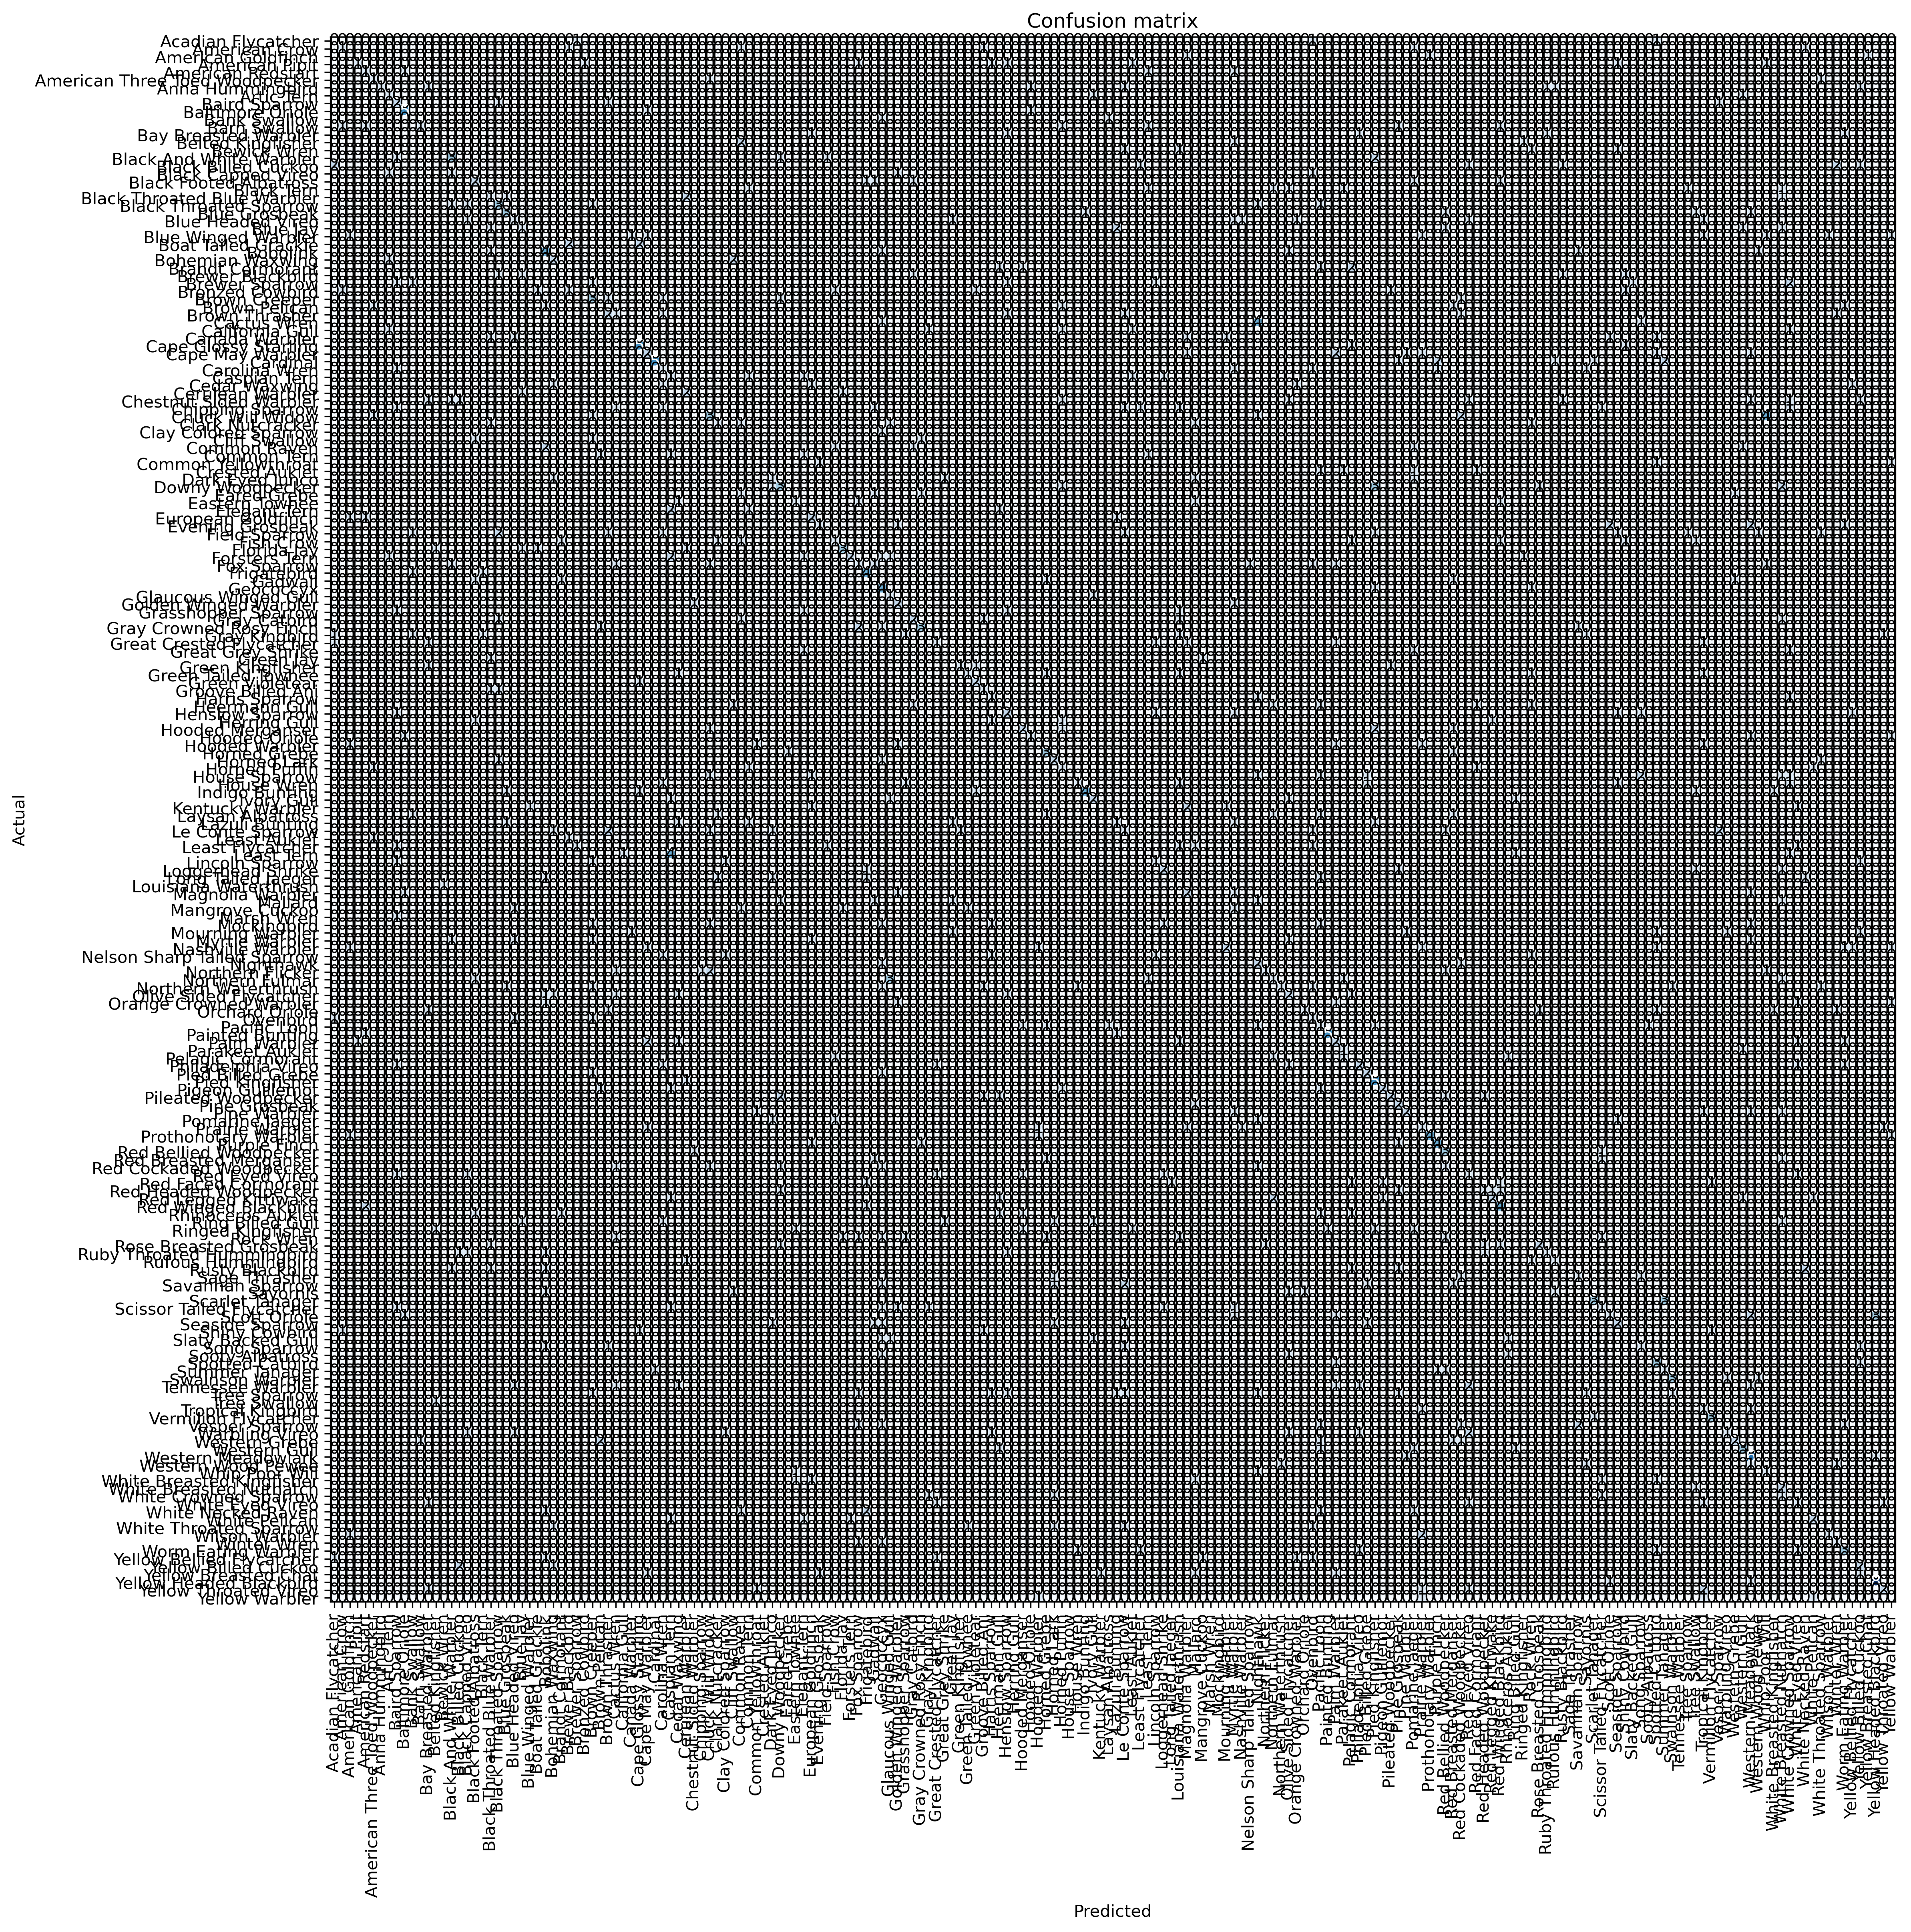

In [109]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=300) #no sé por qué pensé que lo podría lograr... no veo nada.

Bueno, tal vez es mal momento, pero me encontré esto e internet y tengo ganas de intentarlo:

In [110]:
learner_final_2.fine_tune(1,base_lr=0.1)

Creo que, entonces, mi learner va en la dirección correcta... hummm

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=7.585775847473997e-07)

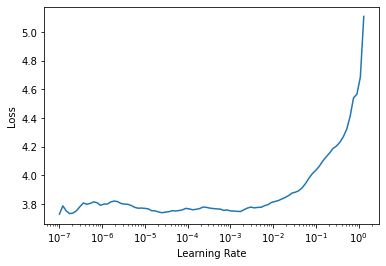

In [111]:
learner_final_2.lr_find()

In [114]:
learner_final_2.save("StageExtra1")
learner_final_2.fit_one_cycle(7,lr_max=5e-6)

Nope, parece que mi idea no era tan buena, la verdad. Aunque, como ya lo guardé, se me antoja seguir moviéndole, la verdad.

In [115]:
learner_final_2.fine_tune(10,base_lr=0.1) #Dios, debí dejarlo como estaba....

KeyboardInterrupt: 

Bueno, ya experimenté: en este caso mi learner no iba en la dirección correcta, así que ni modo. 

## Finalmente: 
Crea una Transform que se aplique aleatoriamente con probabilidad 1/10 que convierta a la imagen en blanco y negro (escala de grises).

In [127]:
!ls flowers/train/primula

image_03641.jpg  image_03665.jpg  image_03688.jpg  image_03712.jpg
image_03643.jpg  image_03667.jpg  image_03689.jpg  image_03714.jpg
image_03644.jpg  image_03668.jpg  image_03690.jpg  image_03715.jpg
image_03645.jpg  image_03669.jpg  image_03691.jpg  image_03716.jpg
image_03646.jpg  image_03670.jpg  image_03692.jpg  image_03717.jpg
image_03647.jpg  image_03671.jpg  image_03693.jpg  image_03718.jpg
image_03648.jpg  image_03672.jpg  image_03694.jpg  image_03719.jpg
image_03649.jpg  image_03673.jpg  image_03695.jpg  image_03720.jpg
image_03650.jpg  image_03674.jpg  image_03696.jpg  image_03721.jpg
image_03651.jpg  image_03675.jpg  image_03697.jpg  image_03722.jpg
image_03653.jpg  image_03676.jpg  image_03698.jpg  image_03723.jpg
image_03654.jpg  image_03677.jpg  image_03699.jpg  image_03724.jpg
image_03655.jpg  image_03678.jpg  image_03700.jpg  image_03725.jpg
image_03656.jpg  image_03679.jpg  image_03702.jpg  image_03726.jpg
image_03657.jpg  image_03680.jpg  image_03704.jpg  image_03727

In [86]:
from PIL import Image
import random

In [87]:
imagen = Image.open("flowers/train/primula/image_03705.jpg")

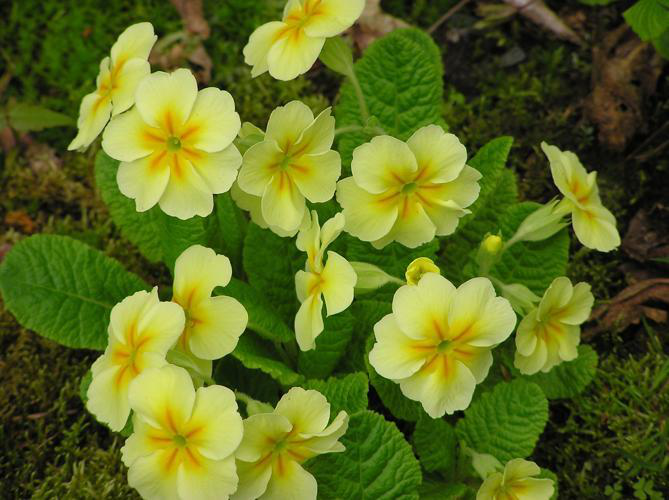

In [88]:
imagen

In [89]:
def grayScale(image):
    print("here is a new transform")
    if random.randrange(10) ==0:
        to_tensor = ToTensor()
        to_image = ToPILImage()
        X = to_tensor(image)
        return(to_image(X[2,:,:]))
    else:
        return(image)

here is a new transform


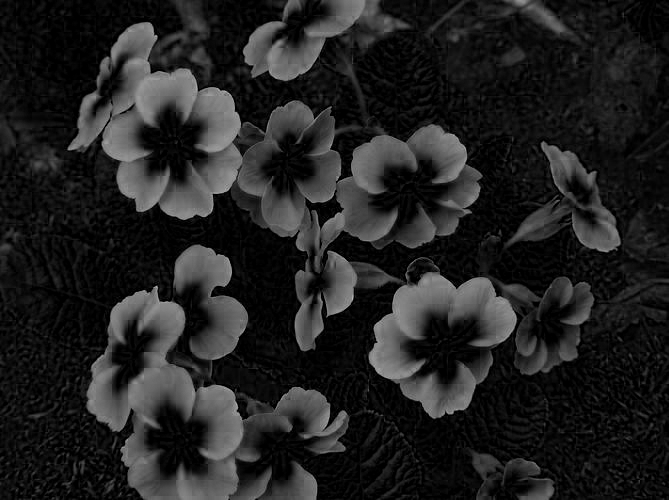

In [93]:
grayScale(imagen)

In [94]:
class randomGrey(fv.Transform):
    def __init__(self , grayScale):
        #super().__init__()
        self.grayScale = grayScale

    def encodes(self, img: fv.TensorImage):
        gray_scale = self.grayScale(img)
        return(gray_scale)
    
    

In [95]:
def load_data_new(folder, img_size, batch_size):  
    tfms = fv.aug_transforms(flip_vert=True, 
                             max_rotate=360, 
                             max_lighting=0.45,
                             max_zoom=1.2,
                             max_warp=0.42,
                             xtra_tfms=randomGrey(grayScale),
                            )
    
    data = fv.DataBlock(
                        blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(folder,bs=batch_size)

In [96]:
flores_nuevo = load_data_new(flowers, img_size=224, batch_size=9)

here is a new transform


here is a new transform


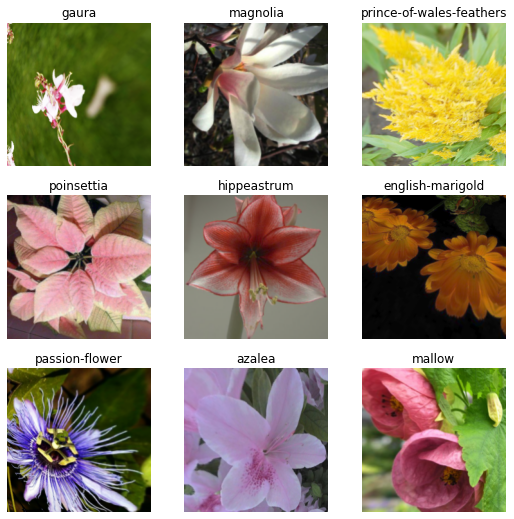

In [103]:
flores_nuevo.show_batch()